In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
file_path = "C:/Users/Sigal/Desktop/water/eea54e96-d51e-4def-b975-bd409eda7c64.csv"  # הכנס את המיקום של קובץ הנתונים
data = pd.read_csv(file_path)

In [3]:
data.shape

(48798, 11)

In [4]:
data.columns

Index(['מספר זיהוי', 'שם עברית', 'שם אנגלית', 'מוסד דוגם', 'מעבדה',
       'תאריך דגימה', 'סימן גדול/קטן', 'תוצאה', 'סמל פרמטר', 'תאור מקוצר',
       'יחידת מידה'],
      dtype='object')

# Data Preprocessing


* missing values.
*  Reshaping the data using a pivot table for easier analysis
* Converting categorical variables to numerical.

## missing values

In [5]:
missing_summary = data.isnull().sum()
print(missing_summary)

מספר זיהוי           0
שם עברית             0
שם אנגלית          811
מוסד דוגם            0
מעבדה                0
תאריך דגימה          0
סימן גדול/קטן    48449
תוצאה                0
סמל פרמטר         4253
תאור מקוצר           0
יחידת מידה           0
dtype: int64


In [6]:
data = data.drop(columns=['שם אנגלית'])
data = data.drop(columns=['סימן גדול/קטן'])

In [7]:
missing_symbol = data[data['סמל פרמטר'].isnull()]
print(missing_symbol[['תאור מקוצר', 'תוצאה']].head())

   תאור מקוצר  תוצאה
22  SODIUM AS  24.26
67  SODIUM AS  11.10
75  SODIUM AS  18.00
88  SODIUM AS  10.00
96  SODIUM AS  10.00


* Checking rows with missing values in the "סמל פרמטר" column and examining the possibility of using the "תאור מקוצר" and "תוצאה" columns of those missing values for filling
*  As we can see in the data frame, the missing values have matching descriptions in the "תאור מקוצר" column, so we will fill the missing values with their short descriptions


In [8]:
data['סמל פרמטר'] = data['סמל פרמטר'].fillna(data['תאור מקוצר'])
data = data.dropna(subset=['סמל פרמטר'])
unique_symbols = data['סמל פרמטר'].unique()
print(unique_symbols)

['Cl' 'HARD' 'PHFD' 'TDS' 'B' 'CA' 'HCO3' 'K' 'Mg' 'SODIUM AS' 'NO3' 'SO4'
 'SILT' 'EC' 'BR' 'TN-N' 'TOC' 'SR' 'PO4' 'DO' 'F' 'T' 'DP-P' 'PFBS'
 'PFHpA' 'PFHxA' 'PFOA' 'PFOS' 'ECFD' 'TURB' 'NO2' 'ORP' 'CARBO' 'CAFFE']


In [9]:
missing_summary = data.isnull().sum()
print(missing_summary)

מספר זיהוי     0
שם עברית       0
מוסד דוגם      0
מעבדה          0
תאריך דגימה    0
תוצאה          0
סמל פרמטר      0
תאור מקוצר     0
יחידת מידה     0
dtype: int64


###  Reshaping the data using a pivot table for easier analysis

* Creating a pivot table to organize the dataset

In [10]:
pivot_data = data.pivot_table(
    index=['מספר זיהוי', 'שם עברית', 'תאריך דגימה'],
    columns='סמל פרמטר',
    values='תוצאה',
    aggfunc='first'
).reset_index()
pivot_data.columns.name = None
print(pivot_data.head())
pivot_data.to_csv("pivoted_water_data.csv", index=False)


   מספר זיהוי          שם עברית       תאריך דגימה     B  BR     CA  CAFFE  \
0        1105  בצת - ע''י אילון  09/11/1954 00:00   NaN NaN    NaN    NaN   
1        1105  בצת - ע''י אילון  21/04/1955 00:00   NaN NaN    NaN    NaN   
2        1105  בצת - ע''י אילון  23/12/2002 00:00  0.64 NaN  20.14    NaN   
3        1105  בצת - ע''י אילון  26/10/1955 00:00   NaN NaN    NaN    NaN   
4        1105  בצת - ע''י אילון  29/03/1956 00:00   NaN NaN    NaN    NaN   

   CARBO     Cl  DO  ...  PO4  SILT   SO4  SODIUM AS  SR   T    TDS  TN-N  \
0    NaN  25.00 NaN  ...  NaN   NaN   NaN        NaN NaN NaN  282.0   NaN   
1    NaN  25.00 NaN  ...  NaN   NaN   NaN        NaN NaN NaN  265.0   NaN   
2    NaN  20.29 NaN  ...  NaN   NaN  11.4      24.26 NaN NaN    NaN   NaN   
3    NaN  25.00 NaN  ...  NaN   NaN   NaN        NaN NaN NaN  360.0   NaN   
4    NaN  30.00 NaN  ...  NaN   NaN   NaN        NaN NaN NaN  290.0   NaN   

   TOC  TURB  
0  NaN   NaN  
1  NaN   NaN  
2  NaN   NaN  
3  NaN   NaN  

* now we will call this new data, and we will keep working on this data from now on. 

In [11]:
file_path = "C:/Users/Sigal/Desktop/water/pivoted_water_data.csv" 
pivoted_water_data = pd.read_csv(file_path)

### new Data Preprocessing

* we will convert tarich dgima column to datetime format
* we wil Separate the date and time into two columns
* Drop the original combined date-time column

In [12]:
pivoted_water_data['תאריך דגימה'] = pd.to_datetime(pivoted_water_data['תאריך דגימה'], errors='coerce')

pivoted_water_data['Date'] = pivoted_water_data['תאריך דגימה'].dt.date  # Extract the date
pivoted_water_data['Time'] = pivoted_water_data['תאריך דגימה'].dt.time  # Extract the time

pivoted_water_data = pivoted_water_data.drop(columns=['תאריך דגימה'], errors='ignore')

### missng values in new data

In [13]:
missing_values = pivoted_water_data.isnull().sum().sort_values(ascending=False)
print(missing_values)
missing_percentage = (missing_values / len(pivoted_water_data)) * 100
print(missing_percentage)

PFBS          9227
PFOS          9227
PFHxA         9227
PFOA          9227
PFHpA         9227
CAFFE         9226
NO2           9226
DP-P          9226
CARBO         9219
TURB          9211
PO4           9204
F             9204
TOC           9082
TN-N          9082
SR            9023
ORP           8834
DO            8822
ECFD          8803
T             8795
B             8624
HARD          8580
PHFD          8440
TDS           8302
EC            8175
SILT          7858
BR            7651
Time          5718
Date          5718
K             4977
SODIUM AS     4975
SO4           4957
Mg            4913
HCO3          4857
CA            4853
NO3           3847
Cl             853
מספר זיהוי       0
שם עברית         0
dtype: int64
PFBS          99.989163
PFOS          99.989163
PFHxA         99.989163
PFOA          99.989163
PFHpA         99.989163
CAFFE         99.978327
NO2           99.978327
DP-P          99.978327
CARBO         99.902471
TURB          99.815778
PO4           99.739922
F

* we can see that there is a lot of missing valus. we dicided to drop all of the colums that have more 
then 80% mising valus. 

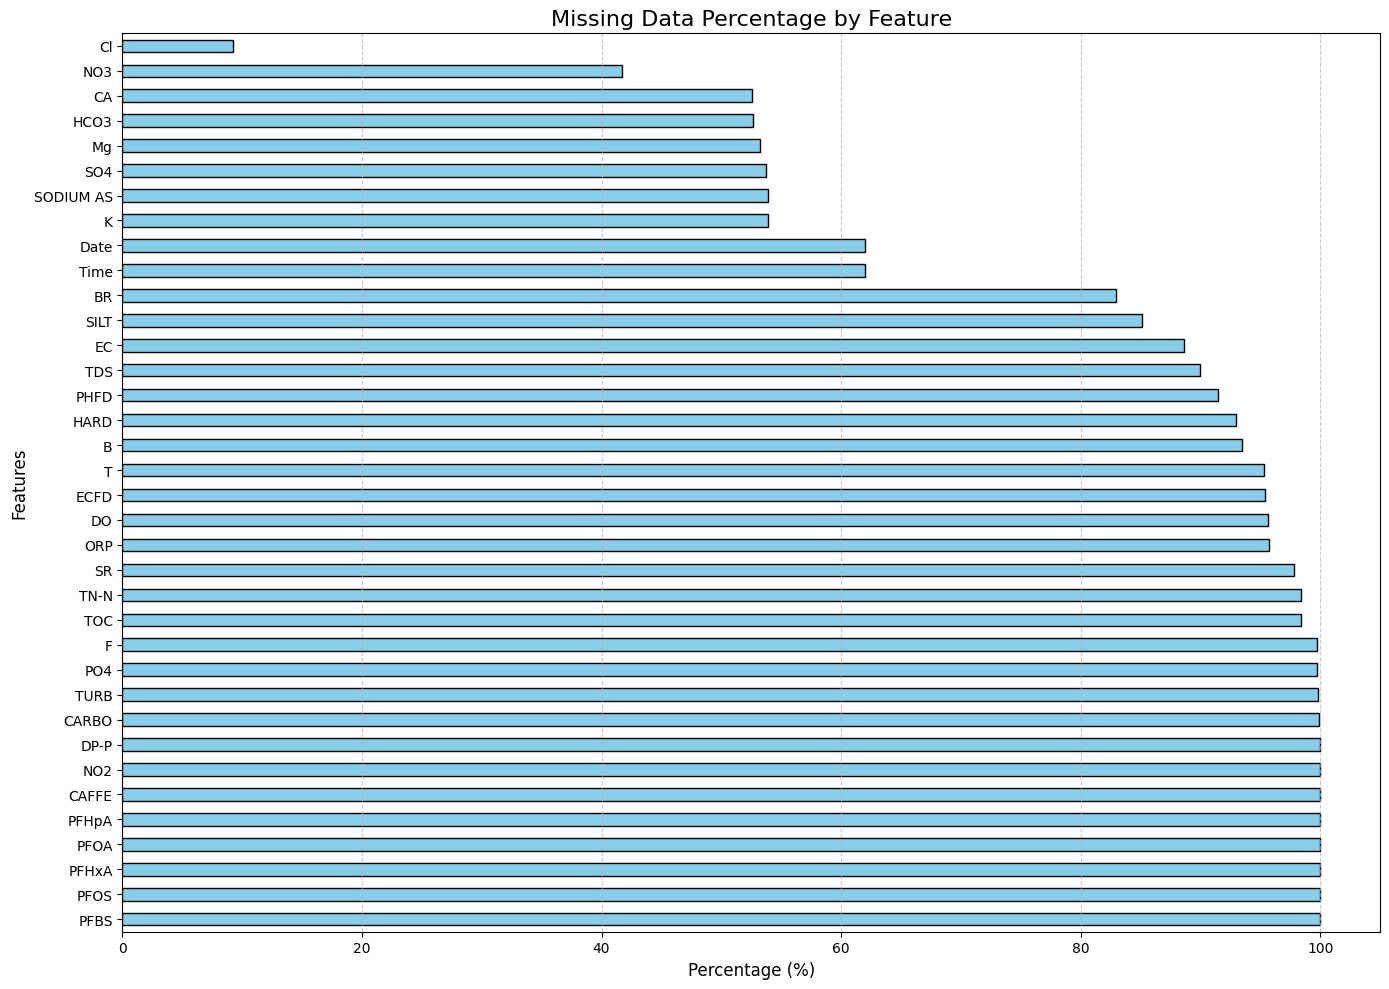

In [17]:
missing_values = pivoted_water_data.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(pivoted_water_data)) * 100
missing_percentage_filtered = missing_percentage[missing_percentage > 1]

plt.figure(figsize=(14, 10))
missing_percentage_filtered.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Missing Data Percentage by Feature', fontsize=16)
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [18]:
columns_to_drop = [
    'B', 'CAFFE', 'CARBO', 'DO', 'DP-P', 'NO2', 'PFBS', 'PFHpA', 'PFHxA', 'PFOA', 'PFOS','PO4', 'TURB','BR', 'EC', 'ECFD', 'F', 'HARD', 'ORP', 'PHFD',
    'SILT', 'SR', 'T', 'TDS', 'TN-N', 'TOC'
]
pivoted_water_data = pivoted_water_data.drop(columns=columns_to_drop)

* We decided not to use rows with missing values, and instead of filling these missing values with the median or another placeholder, * we chose to remove rows with any missing values. This is because filling in missing values would not provide accurate results and * could potentially affect the findings. Therefore, we will remove any rows that contain even a single missing value.

In [19]:
no_nulls_data = pivoted_water_data.dropna() 

In [20]:
print(no_nulls_data.shape[0])

1365


* Now, we will change the column names from Hebrew to English.
* extract the Year and Month from the Date

In [21]:
columns_mapping_partial = {
    'שם עברית': 'Station_Name',
    'מספר זיהוי': 'Station_ID'
}
no_nulls_data.rename(columns=columns_mapping_partial, inplace=True)


C:\Users\Sigal\AppData\Local\Temp\ipykernel_15532\3754595428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_nulls_data.rename(columns=columns_mapping_partial, inplace=True)


In [22]:
no_nulls_data['Year'] = pd.to_datetime(no_nulls_data['Date']).dt.year
no_nulls_data['Month'] = pd.to_datetime(no_nulls_data['Date']).dt.month
no_nulls_data = no_nulls_data.drop(columns=['Date', 'Time'], errors='ignore')

C:\Users\Sigal\AppData\Local\Temp\ipykernel_15532\224095674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_nulls_data['Year'] = pd.to_datetime(no_nulls_data['Date']).dt.year
C:\Users\Sigal\AppData\Local\Temp\ipykernel_15532\224095674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_nulls_data['Month'] = pd.to_datetime(no_nulls_data['Date']).dt.month


* Save new data to csv

In [23]:
no_nulls_data.to_csv("no_nulls_water_data.csv", index=False)

In [24]:
no_nulls_data.describe()

,Station_ID,CA,Cl,HCO3,K,Mg,NO3,SO4,SODIUM AS,Year,Month
count,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000,1365.000000
mean,22207.769963,101.126197,396.886268,242.386557,14.995312,40.840056,19.856918,100.898914,196.343951,2009.509158,6.449084
std,11188.910000,84.560279,674.758075,142.437933,20.459795,65.932648,26.429498,187.466751,313.917443,9.405150,3.603285
min,2105.000000,12.300000,5.000000,51.000000,0.200000,1.065000,0.000000,0.000000,2.100000,1985.000000,1.000000
25%,13150.000000,43.800000,23.000000,158.700000,3.600000,7.500000,5.520000,16.000000,18.100000,2005.000000,3.000000
50%,18140.000000,65.200000,57.400000,221.900000,6.500000,12.900000,12.300000,30.000000,36.650000,2012.000000,7.000000
75%,31110.000000,127.200000,320.600000,303.000000,20.000000,37.200000,22.800000,104.340000,181.400000,2016.000000,10.000000
max,59181.000000,570.600000,5310.537000,3290.000000,197.400000,603.800000,254.200000,1956.100000,2340.900000,2023.000000,12.000000


# bulding new colum 

* During our work on the dataset, we noticed that we didn't have an explanatory column (variable, Y). 
Initially, we considered using the column indicating greater/less/equal as the explanatory variable, 
but we found that it was mostly incomplete. 

* To address this, we realized that each parameter has a well-defined range of acceptable values. 
We researched and found an article that provided the standard ranges for each parameter. 
We incorporated this information as a dictionary into our code and created a new column
called `Station_Compliance` to indicate whether a station meets the standards or not.

* The article "Analysis of Ground Water Quality Parameters" examines the quality of groundwater by analyzing its chemical composition to determine its compliance with safety and environmental standards. The authors emphasize the importance of monitoring groundwater to identify potential contaminants and ensure it meets regulatory guidelines for human consumption. They provide acceptable ranges for key chemical parameters such as Cl, NO3, SO4, Mg, Ca, HCO3, which serve as benchmarks for evaluating water quality. These ranges are aligned with established environmental and health standards, ensuring their reliability for practical application.

* The article builds its standards for water quality assessment by integrating recognized international indices like CWQI, national standards like BIS, comprehensive statistical analyses, and previously published research. These sources collectively establish the acceptable ranges for chemical parameters and their implications for groundwater quality.

* LINK- https://d1wqtxts1xzle7.cloudfront.net/84180824/3.ISCA-RJEngS-2014-24-libre.pdf?1650002584=&response-content-disposition=inline%3B+filename%3DAnalysis_of_Ground_Water_Quality_Paramet.pdf&Expires=1736619565&Signature=AVQeRQyNCETFntI97I4fK1cXgpymbDOWJhW~5TzxM85MeJPfdoEQ9QXdDyc2KbRksd57uTP1mxU6ZWaM6pVrKEChVA8RckTtyp1GhqPHe1RxUVhbTZkPs~nyQFrECfr3XkcRIDKIfTUEf4bPl6tztkBN0QfU6CpJVmivUpjF8XuxQYvxqgO4JN0rfVdoF3mpEpKqIgQf9ET1NmbwM6yalZwjQc-J6B2WWMBXHvhQdbyH4pptT7kw3NnWcJPtTtMz9f0ln~mJHmUxE-s3ttK3wS6~DMrmblUk16jiHu51IUF06NVe3TyfzH8m5v5sSRWQncXfwIm4Vr7BN0WMBj05dw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA

* 



In [25]:
standards = {
    'Cl': {'min': 0, 'max': 250},          
    'NO3': {'min': 0, 'max': 50},         
    'SO4': {'min': 0, 'max': 250},       
    'Mg': {'min': 0, 'max': 50},         
    'CA': {'min': 0, 'max': 400},        
    'HCO3': {'min': 0, 'max': 400},      
    'K': {'min': 0, 'max': 12},          
    'SODIUM AS': {'min': 0, 'max': 200} 
}



* the function- 

In [26]:
def is_value_compliant(param, value):
    if param in standards:  
        limits = standards[param]
        if 'min' in limits and 'max' in limits:
            return limits['min'] <= value <= limits['max']
    return True 

def check_station_compliance(row):
    for param in standards.keys():
        value = row.get(param, None)
        if pd.notnull(value) and not is_value_compliant(param, value):
            return 0  # bad
    return 1  # good

* the new colum

In [27]:
no_nulls_data['Station_Compliance'] = no_nulls_data.apply(check_station_compliance, axis=1)

compliance_summary = no_nulls_data['Station_Compliance'].value_counts()
print(compliance_summary)

Station_Compliance
1    823
0    542
Name: count, dtype: int64


* the number of Compliance Station

### Distribution of Stations by Specific Parameters

* To analyze the dataset further, we examined the distribution of stations.

C:\Users\Sigal\AppData\Local\Temp\ipykernel_15532\3576395165.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=no_nulls_data, x='Station_Compliance', palette=['#1f77b4', '#ff7f0e'])


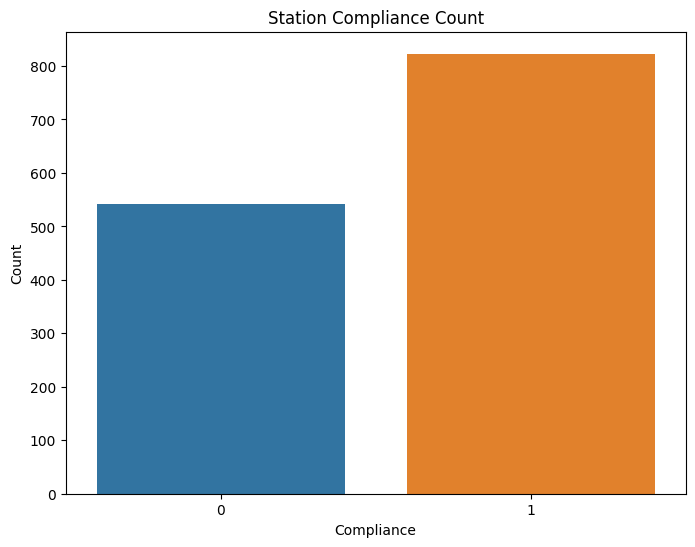

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(data=no_nulls_data, x='Station_Compliance', palette=['#1f77b4', '#ff7f0e'])
plt.title("Station Compliance Count")
plt.xlabel("Compliance")
plt.ylabel("Count")
plt.show()

### Distribution of Key Parameters

To better understand the dataset, we analyzed the distribution of key parameters such as `Cl`, `NO3`, `SO4`, and `CA`.
These parameters play a crucial role in determining water quality and station compliance. 
By visualizing their distributions, we aim to identify patterns, outliers, and general trends that could influence the analysis and
modeling process.


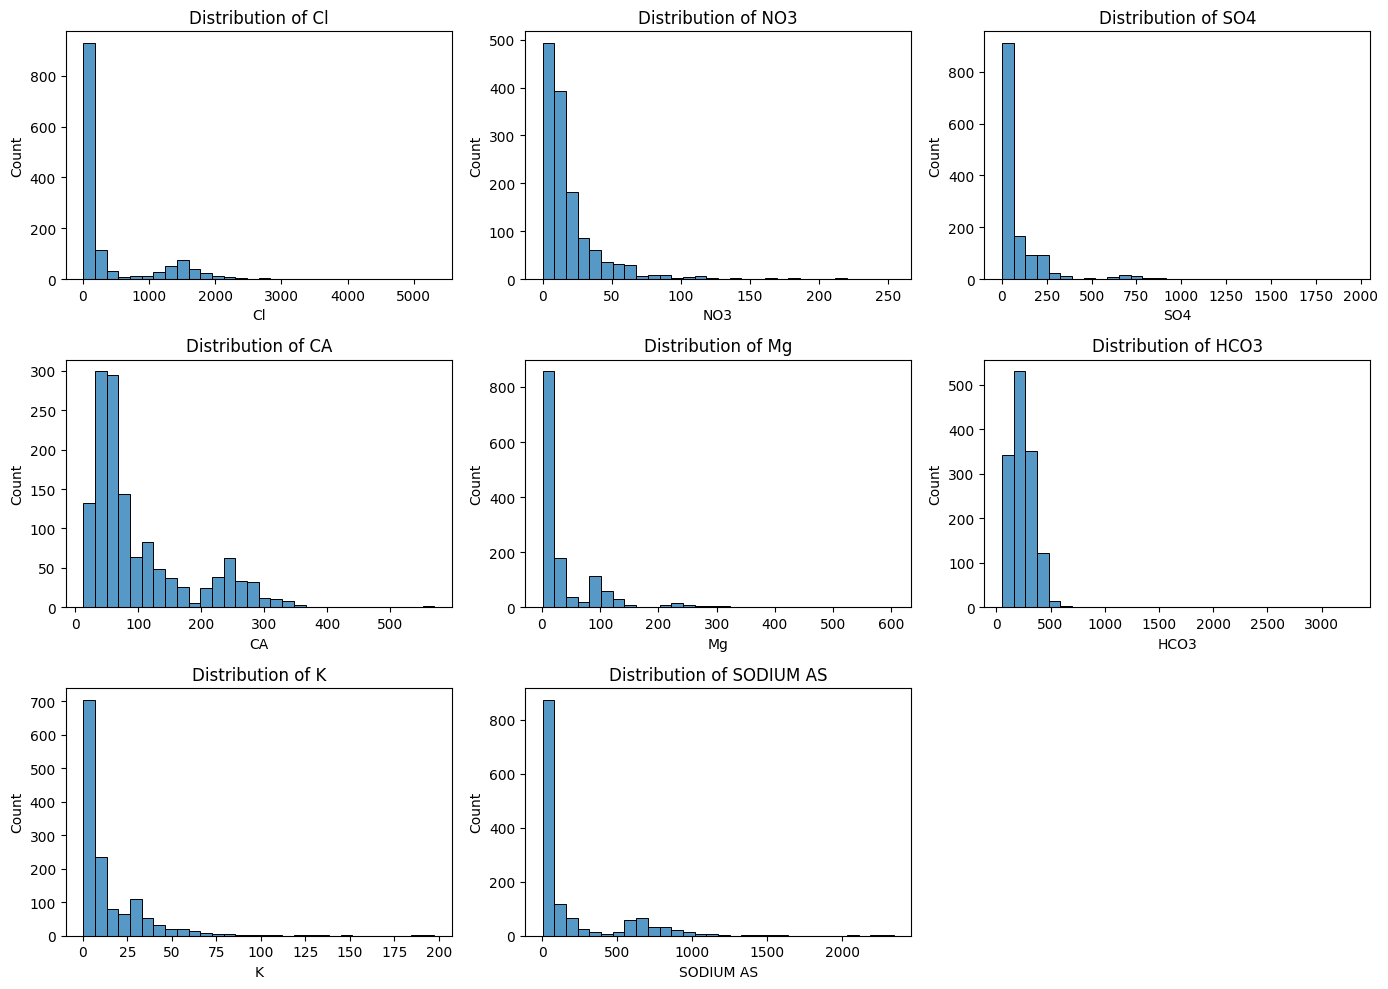

In [29]:
parameters = ['Cl', 'NO3', 'SO4', 'CA', 'Mg', 'HCO3', 'K', 'SODIUM AS']

plt.figure(figsize=(14, 10))
for i, param in enumerate(parameters, 1):
    plt.subplot(3, 3, i)
    sns.histplot(no_nulls_data[param], bins=30, color='#1f77b4')
    plt.title(f"Distribution of {param}")
plt.tight_layout()
plt.show()

* The distributions of the key parameters (e.g., Cl, NO3, SO4, etc.) show that most values are concentrated in a smaller range, with a few outliers in higher ranges. This suggests that while the majority of stations meet standard levels, some stations may have extreme values, possibly due to being non-compliant with water quality standards.

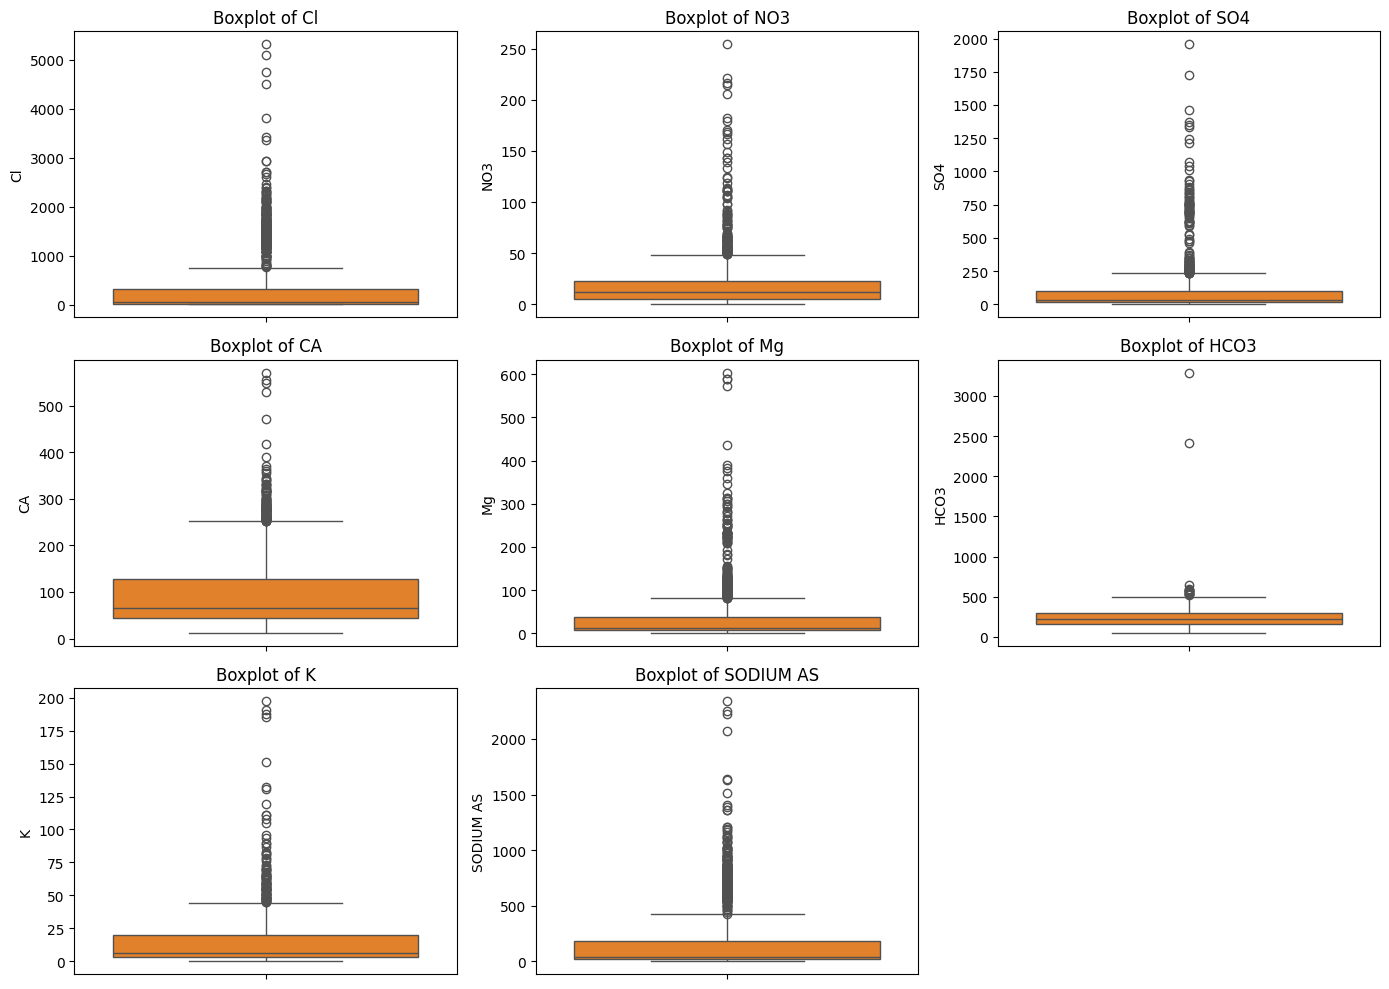

In [30]:
plt.figure(figsize=(14, 10))
for i, param in enumerate(parameters, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=no_nulls_data, y=param, color='#ff7f0e')
    plt.title(f"Boxplot of {param}")
plt.tight_layout()
plt.show()

* After attempting to remove outliers, I realized it is not effective for the dataset because the outliers represent many of the
  non-compliant stations. Removing them would distort the reality of the data. 

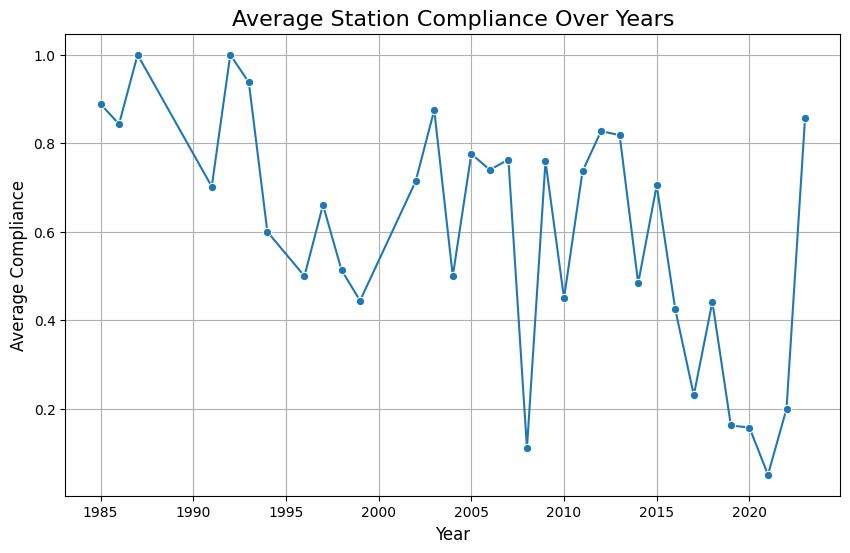

In [31]:
yearly_compliance = no_nulls_data.groupby('Year')['Station_Compliance'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_compliance, marker='o')
plt.title('Average Station Compliance Over Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Compliance', fontsize=12)
plt.grid(True)
plt.show()


* The graph illustrates the average station compliance over the years. It shows fluctuations in compliance levels, with higher compliance rates observed in earlier years, followed by a noticeable decline after 2005. The recent years indicate lower average compliance, suggesting a potential decrease in water quality or stricter standards being applied to stations. The variability highlights the need for further investigation into the reasons behind these trends.

In [ ]:
monthly_compliance = no_nulls_data.groupby('Month')['Station_Compliance'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_compliance, marker='o')
plt.title('Average Station Compliance by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Compliance', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

* The graph shows the average station compliance by month. Compliance levels appear to vary throughout the year, with lower compliance observed in the early months (January to March) and higher compliance during the later months, peaking in December. This trend may suggest seasonal factors influencing water quality or station performance. Further investigation is needed to determine the causes of this pattern.

### Now, we will examine the correlation between numeric features.

In [ ]:
selected_columns = ['Cl', 'NO3', 'SO4', 'CA', 'Mg', 'HCO3', 'K', 'SODIUM AS', 'Year', 'Month', 'Station_Compliance']
correlation_matrix_filtered = no_nulls_data[selected_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_filtered, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Filtered Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

* The correlation matrix shows the relationships between the features in the dataset.

High correlation:For example, Cl has a very high correlation with SODIUM AS (0.99), and Mg is highly correlated with CA (0.84). Such high correlations indicate redundancy, meaning these features provide similar information. Hence, we decided to remove Mg, Cl, and SODIUM AS to avoid multicollinearity in the analysis.
Low correlation with the target (Station_Compliance):

Some features, like Month and Year, have very low correlations with Station_Compliance (-0.23 for Year and 0.10 for Month). We decided to remove both Month and Year since they don't significantly contribute to predicting compliance.
By reducing redundant and irrelevant features, we ensure that the model focuses on the most informative parameters, improving its performance and interpretability.

In [ ]:
filtered_data = no_nulls_data.drop(columns=['Mg','Cl','SODIUM AS','Year','Month',], errors='ignore')

filtered_data.to_csv("filtered_no_nulls_data.csv", index=False)
print("Filtered dataset saved to 'filtered_no_nulls_data.csv'.")

In [ ]:
selected_columns = ['NO3', 'CA', 'SO4', 'HCO3', 'K', 'Station_Compliance']
correlation_matrix_filtered = filtered_data[selected_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_filtered, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Filtered Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

* coralition with the filterd data

### Steps for Building the Models

2. **Data Splitting**:
   - Split the dataset into training and testing sets to evaluate model performance.

3. **Model Selection**:
   - Chose five classification models: Logistic Regression, Random Forest, Decision Tree, Gradient Boosting, and SVM.

4. **Model Evaluation**:
   - Used metrics such as Accuracy, Precision, Recall, and F1-Score to evaluate model performance.

5. **Cross-Validation**:
   - Applied cross-validation to ensure consistency and robustness in the results.


In [ ]:
X = filtered_data.drop(columns=['Station_Compliance']).select_dtypes(include=['float64', 'int64'])
y = filtered_data['Station_Compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

In [ ]:
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

results_df = pd.DataFrame(results)
print(results_df)


##### Since the target column we are predicting, which represents water quality, is directly based on the values of all the chemical parameters in the water, it is clear that we can reliably and accurately predict water quality using these chemical parameters. Additionally, the task is a binary classification (0/1), which is a relatively straightforward task.

### Model Analysis and Results

1. **Logistic Regression**  
   - **Accuracy**: 93.41%  
   Logistic Regression performed well with high accuracy and balanced metrics. It works effectively for binary classification tasks but might miss complex patterns compared to more advanced models.

2. **Random Forest**  
   - **Accuracy**: 97.80%  
   Random Forest showed better results than Logistic Regression, thanks to its ability to handle non-linear relationships through ensemble learning. It’s a strong and reliable model for this dataset.

3. **Decision Tree**  
   - **Accuracy**: 99.26%  
   Decision Tree had the best accuracy among all models. It works well for binary classification by creating clear decision boundaries. However, there’s a risk of overfitting, so it needs further validation.

4. **Gradient Boosting**  
   - **Accuracy**: 98.53%  
   Gradient Boosting performed very well, just slightly below the Decision Tree model. Its iterative learning process makes it effective and provides a good balance between performance and stability.

5. **SVM (Support Vector Machine)**  
   - **Accuracy**: 71.79%  
   SVM struggled with this dataset, showing the lowest accuracy. It likely requires more parameter tuning to perform better and may not be the best choice for this task.

---

### Best Model
The **Decision Tree model** achieved the highest accuracy (99.26%) and performed well overall. However, there’s a chance of overfitting, so it should be further validated.  


### Decision Tree Model Steps:
2. Calculated accuracy on both training and testing sets.
3. Checked for overfitting by comparing training and testing accuracies. If the difference is significant, the model might overfit.


In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
train_accuracy = accuracy_score(y_train, decision_tree.predict(X_train))
test_accuracy = accuracy_score(y_test, decision_tree.predict(X_test))
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


* The train accuracy of 1.0000 means the model perfectly predicts the training data, while the test accuracy of 0.9927 shows it generalizes very well to unseen data. The small difference suggests the model is not overfitting and performs effectively.

# Cross-validation for the Decision Tree model

In [ ]:
decision_tree_limited = DecisionTreeClassifier(max_depth=5, random_state=42)
decision_tree_limited.fit(X_train, y_train)


cv_scores = cross_val_score(decision_tree_limited, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f}")


The Cross-Validation Accuracy of 0.9808 indicates that the model performs consistently well across the training data splits. This suggests that the model is robust and not overfitting to a specific portion of the training data.

# Extract feature importance

In [ ]:
features = X_train.columns
feature_importance = decision_tree_limited.feature_importances_
sorted_indices = feature_importance.argsort()

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_indices], feature_importance[sorted_indices], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

The feature importance plot shows that CA (Calcium) and K (Potassium) are the most significant features contributing to the model's predictions. Other features, such as NO3, SO4, and HCO3, have much lower importance, indicating they play a smaller role in determining station compliance.

# Unsupervised Analysis (Clustering)

### Step-by-step explanation of the code:

#### 1. Data Preparation
#### 2. Running Clustering Algorithms:
#### 3. Dimensionality Reduction:
#### 4. Visualization:


#### 1. Data Preparation
*  The relevant columns for clustering are selected (`features_for_clustering`).
- The data is scaled using **StandardScaler**, ensuring that all features are on the same scale.


In [ ]:
features_for_clustering = ['K', 'CA', 'SO4', 'NO3', 'HCO3']
clustering_data = filtered_data[features_for_clustering]

In [ ]:
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

#### Elbow Method to Determine Optimal Number of Clusters

* The Elbow Method helps us find the best number of clusters (k) for K-Means. It works by calculating the clustering error (how well the points fit in their clusters) for different k values. We plot these errors, and the "elbow point" is where the error stops decreasing significantly. This helps us pick a good number of clusters without making the model too complex.

In [ ]:
cluster_errors = [] 
cluster_numbers = range(1, 10)

for k in cluster_numbers:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data_scaled)
    cluster_errors.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_numbers, cluster_errors, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cluster Errors (WCSS)')
plt.title('Elbow Method: Optimal k')
plt.grid(True) 
plt.show()


* The graph shows how WCSS decreases as the number of clusters (k) increases, meaning the clusters better fit the data. The "elbow" point, around k=3 or k=4, marks where the rate of improvement slows significantly. This suggests that 3 or 4 clusters is the optimal choice, balancing accuracy and simplicity. Using this k will help us create meaningful clusters without overfitting the data.

* We will run K-Means and Hierarchical Clustering (both with 3 clusters).
* We will calculate the Silhouette Score and Davies-Bouldin Index to evaluate how well the algorithms performed in clustering the data.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(clustering_data_scaled)

silhouette_kmeans = silhouette_score(clustering_data_scaled, kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(clustering_data_scaled, kmeans_labels)

print(f"K-Means Silhouette Score: {silhouette_kmeans:.4f}")
print(f"K-Means Davies-Bouldin Index: {davies_bouldin_kmeans:.4f}")


In [ ]:
linked = linkage(clustering_data_scaled, 'ward')
clusters_hierarchical = fcluster(linked, 3, criterion='maxclust')

silhouette_hierarchical = silhouette_score(clustering_data_scaled, clusters_hierarchical)
davies_bouldin_hierarchical = davies_bouldin_score(clustering_data_scaled, clusters_hierarchical)

print(f"Hierarchical Clustering Silhouette Score: {silhouette_hierarchical:.4f}")
print(f"Hierarchical Clustering Davies-Bouldin Index: {davies_bouldin_hierarchical:.4f}")


### Cluster Profiling

In [ ]:
cluster_profiles = pd.DataFrame(clustering_data, columns=features_for_clustering)
cluster_profiles['Cluster'] = kmeans_labels
cluster_summary = cluster_profiles.groupby('Cluster').mean()
print("Cluster Summary:")
print(cluster_summary)

### Cluster Summary Analysis

The cluster summary provides average values for important water quality parameters (K, CA, SO4, NO3, HCO3) across three groups:

- **Cluster 0**:
  - Low values for most parameters.
  - Indicates cleaner water with minimal contamination.

- **Cluster 1**:
  - High levels of CA, SO4, and HCO3.
  - Suggests significant pollution in this group.

- **Cluster 2**:
  - Extremely high values of HCO3 and NO3.
  - Points to specific water quality issues requiring further investigation.

### Visualize Cluster Centers

* This code visualizes the cluster centers identified by the K-Means algorithm. Each cluster center represents the average values of the parameters (e.g., K, CA, SO4, NO3, HCO3) for that cluster. The bar chart allows us to easily compare the parameter levels across clusters, helping us understand the key characteristics of each group. For example, it can highlight which clusters have higher contamination levels or cleaner water.




In [ ]:
cluster_centers = kmeans.cluster_centers_
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features_for_clustering)

cluster_centers_df.plot(kind='bar', figsize=(10, 6))
plt.title("Cluster Centers")
plt.ylabel("Parameter Values")
plt.xlabel("Cluster")
plt.xticks(range(len(cluster_centers_df)), [f"Cluster {i}" for i in range(len(cluster_centers_df))])
plt.show()

* The results provide valuable insights into the characteristics of each cluster. Clusters 0 and 1 show relatively balanced and lower parameter values for K, CA, SO4, NO3, and HCO3, indicating stations with stable or less polluted water. On the other hand, Cluster 2 stands out with a significantly higher HCO3 value, suggesting potential anomalies or unusually high bicarbonate concentrations. This could indicate specific regional characteristics or contamination issues. These findings help differentiate the clusters and identify areas for further investigation or targeted action.

### Mapping Clusters to Compliance:

* We cross-tabulate clusters with compliance status to analyze how well clusters align with compliant or non-compliant stations.
* This helps identify if clustering provides insights into water quality compliance patterns.

In [ ]:
compliance_mapping = pd.DataFrame({
    'Cluster': kmeans_labels,
    'Compliance': y
})
cross_tab = pd.crosstab(compliance_mapping['Cluster'], compliance_mapping['Compliance'])
print("Cluster and Compliance Cross Tabulation:")
print(cross_tab)

* Cluster 0: Represents mostly compliant stations but still includes some non-compliant ones.
* Cluster 1 and 2: These clusters are entirely non-compliant, indicating poor water quality. Cluster 2 likely represents extreme cases compared to Cluster 1.
* This result shows that clustering can help group stations based on water quality, highlighting compliant and non-compliant groups for further investigation.

### Heatmaps for Cluster Correlations

* For each cluster, we calculate correlations between parameters and visualize them in a heatmap.
* This helps identify the relationships between parameters within each cluster, revealing unique patterns or dependencies in the data.

In [ ]:
fig, axes = plt.subplots(1, len(np.unique(kmeans_labels)), figsize=(18, 6), constrained_layout=True)
for i, cluster in enumerate(np.unique(kmeans_labels)):
    cluster_data = clustering_data_scaled[kmeans_labels == cluster]
    cluster_corr = np.corrcoef(cluster_data.T)
    
    sns.heatmap(cluster_corr, annot=True, cmap="coolwarm", xticklabels=features_for_clustering, yticklabels=features_for_clustering, ax=axes[i])
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].tick_params(axis='x', labelrotation=45)
fig.suptitle("Correlation Heatmaps for All Clusters", fontsize=16)
plt.show()


* Cluster 0: Moderate correlations are observed between parameters such as SO4 and NO3, as well as HCO3 and CA, suggesting partial interactions or shared patterns.

* Cluster 1: Strong correlations exist between CA and HCO3, indicating these parameters might play a significant role in defining this cluster's characteristics.

* Cluster 2: Almost all parameters show very high correlations, suggesting data homogeneity or a unique trend within this cluster.

* General results: The varying correlations between parameters highlight the distinct characteristics of each cluster, which can reflect different environmental or chemical condition

#### PCA
- We use **PCA** (Principal Component Analysis) to reduce the data to 2 dimensions. This makes it easier to visualize the data in a 2D plot.

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data_scaled)  # Use clustering_data_scaled instead of scaled_data

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_labels, cmap='viridis')
axes[0].set_title('K-Means Clustering')

axes[1].scatter(pca_data[:, 0], pca_data[:, 1], c=clusters_hierarchical, cmap='viridis')
axes[1].set_title('Hierarchical Clustering')

axes[2].scatter(pca_data[:, 0], pca_data[:, 1], c=y, cmap='viridis')
axes[2].set_title('True Labels')

plt.tight_layout()
plt.show()


### Explanation of the Plots:

1. **K-Means Clustering** (First Plot):
   - This plot shows how **K-Means** divided the data into three clusters based on the optimal number of clusters determined earlier.
   - The clusters are well-formed with clear boundaries, and the distribution of points indicates that the algorithm captured the main groupings in the data effectively.

2. **Hierarchical Clustering** (Second Plot):
   - This plot represents the results of **Hierarchical Clustering** with three clusters. While the general separation aligns somewhat with K-Means, the clusters appear less distinct.
   - There is more overlap and potential ambiguity in certain areas, which suggests that Hierarchical Clustering might struggle with clear divisions in this dataset.

3. **True Labels** (Third Plot):
   - This plot displays the actual (ground truth) classifications of the data. The colors represent the true classes for comparison with the clustering results.
   - By comparing this to the first two plots, we can see that both clustering methods capture the general structure but may miss some details in replicating the true labels.

### Conclusion:
- **K-Means Clustering** shows a tighter and more distinct grouping compared to **Hierarchical Clustering**, making it potentially more effective for this dataset.
- While neither clustering method perfectly matches the true labels, **K-Means** provides results closer to the ground truth, with less overlap and clearer separation between clusters.
